In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set random seed 
RSEED = 100

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18


import seaborn as sns
palette = sns.color_palette('Paired', 10)

In [2]:
data = pd.read_csv('input/train.csv', nrows = 5_000_000, 
                   parse_dates = ['pickup_datetime']).drop(columns = 'key')

# Remove na
data = data.dropna()

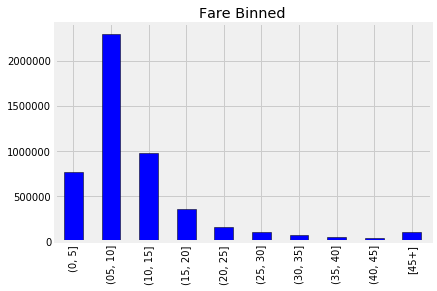

In [3]:
data = data[data['fare_amount'].between(left = 0, right = 100)]
data = data.loc[data['passenger_count'] < 10]

# Remove latitude and longtiude outliers
data = data.loc[data['pickup_latitude'].between(40, 42)]
data = data.loc[data['pickup_longitude'].between(-75, -72)]
data = data.loc[data['dropoff_latitude'].between(40, 42)]
data = data.loc[data['dropoff_longitude'].between(-75, -72)]

# Bin the fare and convert to string
data['fare-bin'] = pd.cut(data['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
data.loc[data['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
data.loc[data['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

# Bar plot of value counts
data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');

In [4]:
# Absolute difference in latitude and longitude
data['abs_lat_diff'] = (data['dropoff_latitude'] - data['pickup_latitude']).abs()
data['abs_lon_diff'] = (data['dropoff_longitude'] - data['pickup_longitude']).abs()

def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

data['manhattan'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 1)

data['euclidean'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 2)

In [5]:
test = pd.read_csv('input/test.csv', parse_dates = ['pickup_datetime'])

test['abs_lat_diff'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()
test['abs_lon_diff'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()

test['manhattan'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 1)

test['euclidean'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 2)

# Save the id for submission
test_id = list(test.pop('key'))

In [6]:
# Radius of hte earth in kilometers
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

data['haversine'] =  haversine_np(data['pickup_longitude'], data['pickup_latitude'],
                         data['dropoff_longitude'], data['dropoff_latitude']) 

test['haversine'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                         test['dropoff_longitude'], test['dropoff_latitude'])

In [7]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')
    
from sklearn.ensemble import RandomForestRegressor

def model_rf(X_train, X_valid, y_train, y_valid, test, features,
             model = RandomForestRegressor(n_estimators = 25, max_depth = 25,
                                           n_jobs = -1)):
    
    # Train
    model.fit(X_train[features], y_train)
    
    # Validation
    evaluate(model, features, X_train, X_valid, y_train, y_valid)
    
    # Make predictions on test and generate submission dataframe
    preds = model.predict(test[features])
    sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features,
                                        'importance': model.feature_importances_}).\
                           sort_values('importance', ascending = False).set_index('feature')
    
    return sub, feature_importances

In [8]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, 
                     start_ref = pd.datetime(1900, 1, 1),
                     extra_attr = False):
    """
    Extract Date Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    

    # Prefix for new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]ime', '', pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'is_leap_year']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
        
    # Calculate days in year
    df[pre + 'Days_in_year'] = df[pre + 'is_leap_year'] + 365
        
    if time:
        # Add fractional time of day (0 - 1) units of day
        df[pre + 'frac_day'] = ((df[pre + 'Hour']) + (df[pre + 'Minute'] / 60) + (df[pre + 'Second'] / 60 / 60)) / 24
        
        # Add fractional time of week (0 - 1) units of week
        df[pre + 'frac_week'] = (df[pre + 'Dayofweek'] + df[pre + 'frac_day']) / 7
    
        # Add fractional time of month (0 - 1) units of month
        df[pre + 'frac_month'] = (df[pre + 'Day'] + (df[pre + 'frac_day'])) / (df[pre + 'Days_in_month'] +  1)
        
        # Add fractional time of year (0 - 1) units of year
        df[pre + 'frac_year'] = (df[pre + 'Dayofyear'] + df[pre + 'frac_day']) / (df[pre + 'Days_in_year'] + 1)
        
    # Add seconds since start of reference
    df[pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

test = extract_dateinfo(test, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())

data = extract_dateinfo(data, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())

# Rounded Distances

In [9]:
rounded_names = []
# Round to two places
for l in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
    
    r = f'{l}-round'
    data[r] = data[l].round(2)
    test[r] = test[l].round(2)
    rounded_names.append(r)
    
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,manhattan,euclidean,...,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed,pickup_latitude-round,pickup_longitude-round,dropoff_latitude-round,dropoff_longitude-round
0,2015-01-27 13:08:24,-73.973,40.764,-73.981,40.744,1,0.020,0.008,0.028,0.022,...,365,0.547,0.221,0.861,0.075,191596058.000,40.760,-73.970,40.740,-73.980
1,2015-01-27 13:08:24,-73.987,40.719,-73.999,40.739,1,0.020,0.012,0.032,0.023,...,365,0.547,0.221,0.861,0.075,191596058.000,40.720,-73.990,40.740,-74.000
2,2011-10-08 11:53:44,-73.983,40.751,-73.980,40.746,1,0.005,0.003,0.008,0.006,...,365,0.496,0.785,0.265,0.769,87306778.000,40.750,-73.980,40.750,-73.980
3,2012-12-01 21:12:12,-73.981,40.768,-73.990,40.752,1,0.016,0.009,0.025,0.019,...,366,0.883,0.840,0.059,0.918,123628286.000,40.770,-73.980,40.750,-73.990
4,2012-12-01 21:12:12,-73.966,40.790,-73.989,40.744,1,0.045,0.023,0.068,0.051,...,366,0.883,0.840,0.059,0.918,123628286.000,40.790,-73.970,40.740,-73.990


In [10]:
test_round = pd.read_csv('input/test_rounded_distances.csv')
test_round.columns = rounded_names + list(test_round.columns[4:])
test_round.head()

,pickup_latitude-round,pickup_longitude-round,dropoff_latitude-round,dropoff_longitude-round,pickup,dropoff,distance,duration
0,40.570,-74.220,40.570,-74.220,"40.57,-74.22","40.57,-74.22",1.000,1.000
1,40.580,-74.250,40.590,-74.260,"40.58,-74.25","40.59,-74.26",3.600,8.000
2,40.590,-73.970,40.590,-73.970,"40.59,-73.97","40.59,-73.97",1.000,1.000
3,40.600,-73.980,40.600,-73.970,"40.6,-73.98","40.6,-73.97",1.500,6.000
4,40.620,-73.990,40.620,-73.990,"40.62,-73.99","40.62,-73.99",1.000,1.000


In [11]:
test = test.merge(test_round, on = rounded_names, how = 'left')

In [12]:
data_round = pd.read_csv('input/rounded_distances.csv')
data_round.columns = rounded_names + list(data_round.columns[4:])
data = data.merge(data_round, on = rounded_names, how = 'left')
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,abs_lat_diff,abs_lon_diff,...,pickup_frac_year,pickup_Elapsed,pickup_latitude-round,pickup_longitude-round,dropoff_latitude-round,dropoff_longitude-round,pickup,dropoff,distance,duration
0,4.500,2009-06-15 17:26:21,-73.844,40.721,-73.842,40.712,1,"(0, 5]",0.009,0.003,...,0.456,14318735.000,40.720,-73.840,40.710,-73.840,"40.72,-73.84","40.71,-73.84",2.700,6.000
1,16.900,2010-01-05 16:52:16,-74.016,40.711,-73.979,40.782,1,"(15, 20]",0.071,0.037,...,0.016,31942290.000,40.710,-74.020,40.780,-73.980,"40.71,-74.02","40.78,-73.98",8.900,28.000
2,5.700,2011-08-18 00:35:00,-73.983,40.761,-73.991,40.751,2,"(05, 10]",0.011,0.009,...,0.628,82859654.000,40.760,-73.980,40.750,-73.990,"40.76,-73.98","40.75,-73.99",2.400,13.000
3,7.700,2012-04-21 04:30:42,-73.987,40.733,-73.992,40.758,1,"(05, 10]",0.025,0.004,...,0.306,104214596.000,40.730,-73.990,40.760,-73.990,"40.73,-73.99","40.76,-73.99",4.500,21.000
4,5.300,2010-03-09 07:51:00,-73.968,40.768,-73.957,40.784,1,"(05, 10]",0.016,0.011,...,0.187,37353014.000,40.770,-73.970,40.780,-73.960,"40.77,-73.97","40.78,-73.96",2.300,9.000


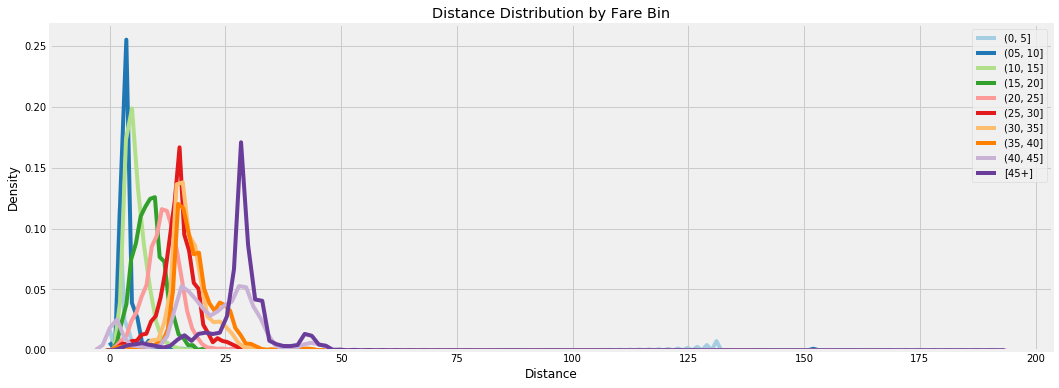

In [13]:
plt.figure(figsize = (16, 6))

for i, (f, grouped) in enumerate(data.groupby('fare-bin')):
    sns.kdeplot(grouped['distance'], label = f'{f}', color = palette[i])

plt.xlabel('Distance'); plt.ylabel('Density'); plt.title('Distance Distribution by Fare Bin');

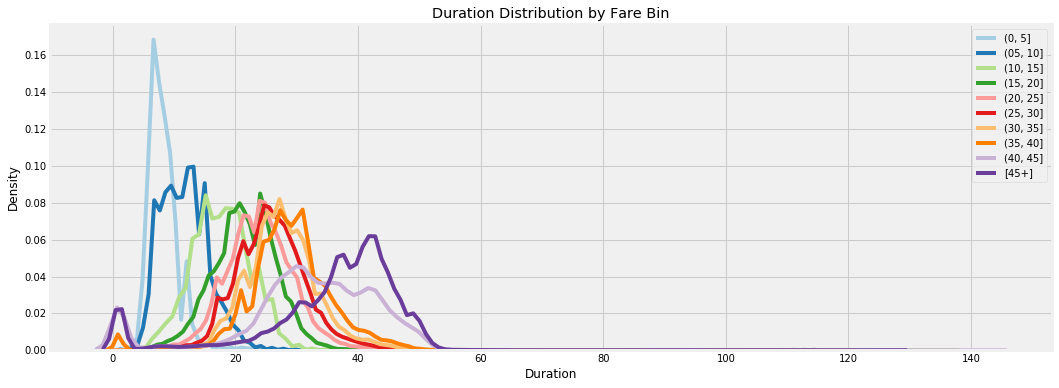

In [14]:
plt.figure(figsize = (16, 6))

for i, (f, grouped) in enumerate(data.groupby('fare-bin')):
    sns.kdeplot(grouped['duration'], label = f'{f}', color = palette[i])

plt.xlabel('Duration'); plt.ylabel('Density'); plt.title('Duration Distribution by Fare Bin');

In [15]:
data = data.fillna(0)
test = test.fillna(0)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 1_000_000)

In [17]:
features = list(data.columns)

for f in ['pickup_datetime', 'fare_amount', 'fare-bin', 'pickup', 'dropoff'] + rounded_names:
    features.remove(f)
    
len(features)

29

In [18]:
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, features)

Training:   rmse = 2.04 	 mape = 13.33
Validation: rmse = 3.38 	 mape = 17.92


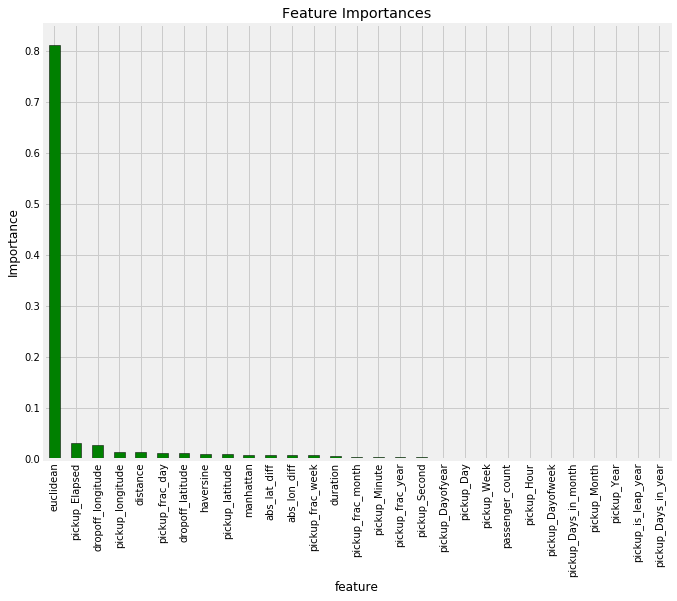

In [32]:
plt.figure(figsize = (10, 8))
fi['importance'].plot.bar(color = 'g', edgecolor = 'k');
plt.ylabel('Importance'); plt.title('Feature Importances');

In [41]:
features = list(fi[fi['importance'] > 0.005].index)
len(features)

13

In [22]:
corrs = data.corr()

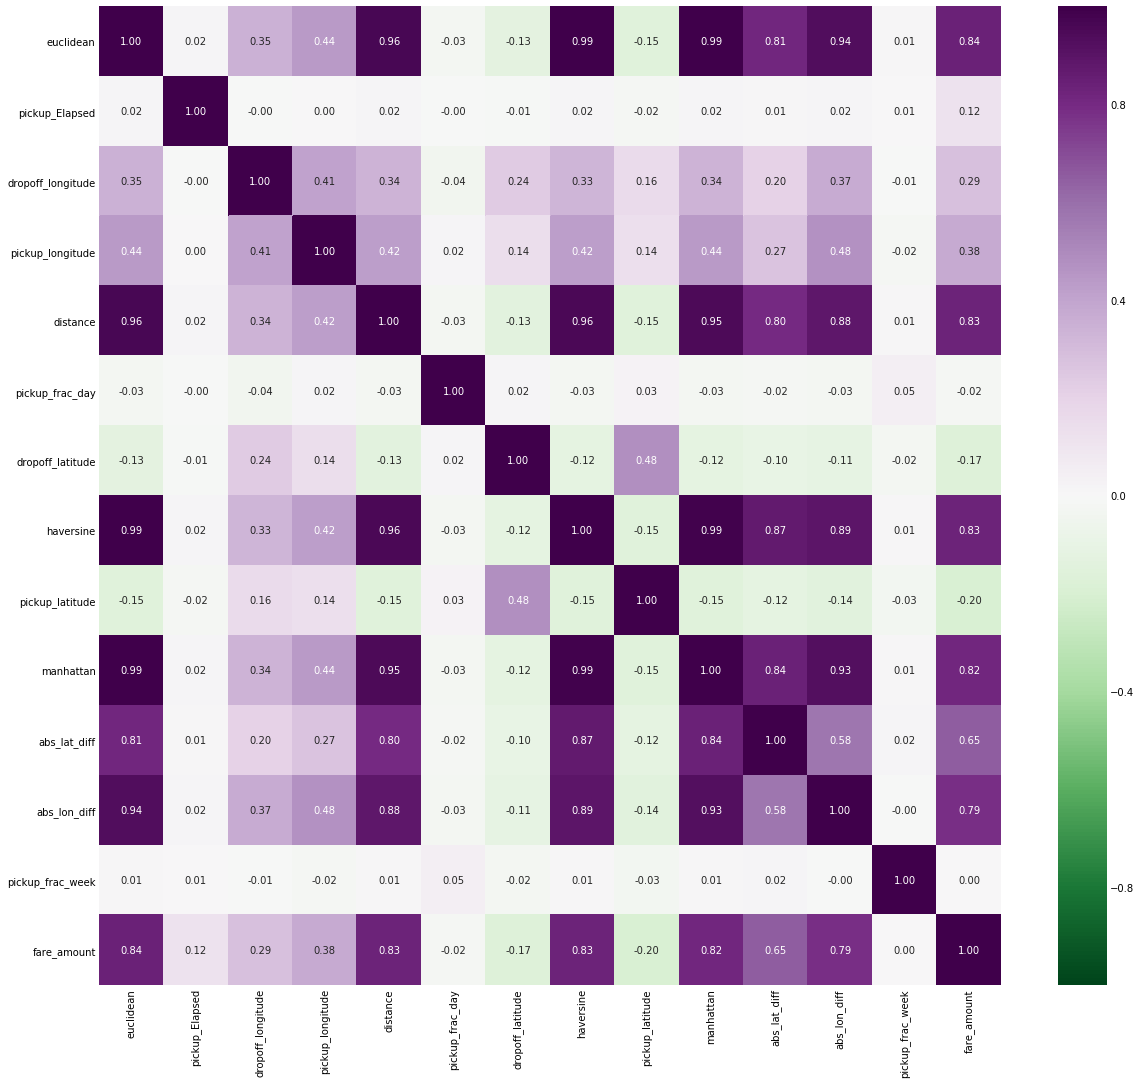

In [43]:
corrs = corrs.loc[features + ['fare_amount'], features + ['fare_amount']]
plt.figure(figsize = (18, 18))
sns.heatmap(corrs, annot = True, fmt = '.2f', vmin = -1, vmax = 1, cmap = plt.cm.PRGn_r);

In [55]:
from sklearn.model_selection import KFold

import lightgbm as lgb

In [52]:
trial_data = data.sample(100_000, random_state=RSEED)

In [73]:
def model_gbm(data, targets, feature_names, test, test_id, 
              nfolds = 3, hyp = None):
    """Model using the gradient boosting machine. Using
    early stopping with cross validation to make predictions.
    """
    
    # Option for user specified hyperparameters
#     if hyp is not None:
#         # Using early stopping so do not need number of esimators
#         if 'n_estimators' in hyp:
#             del hyp['n_estimators']
#         params = hyp
    
#     else:
#         # Model hyperparameters
#         params = {'boosting_type': 'dart', 
#                   'colsample_bytree': 0.88, 
#                   'learning_rate': 0.028, 
#                    'min_child_samples': 10, 
#                    'num_leaves': 36, 'reg_alpha': 0.76, 
#                    'reg_lambda': 0.43, 
#                    'subsample_for_bin': 40000, 
#                    'subsample': 0.54}
    
    # Build the model
    model = lgb.LGBMRegressor(objective = 'regression', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = RSEED)
    
    # Using KFOLD
    kfold = KFold(n_splits = nfolds, shuffle = True)
    
    # Hold all the predictions from each fold
    predictions = np.zeros(len(test))
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    data = np.array(data[feature_names])
    test = np.array(test[feature_names])
    targets = np.array(targets).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(kfold.split(data, targets)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = data[train_indices]
        X_valid = data[valid_indices]
        y_train = targets[train_indices]
        y_valid = targets[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = 'root_mean_squared_error',
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 500)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['rmse'])
        
        # Make predictions from the fold
        predictions = model.predict(test) / nfolds
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        # display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    
    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    sub = pd.DataFrame({'key': test_id, 'fare_amount': predictions})
    
    # return the submission and feature importances
    return sub, feature_importances

In [74]:
sub, fi = model_gbm(data, data['fare_amount'], features, test, test_id)

Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 3.18487	valid's rmse: 3.27628
[1000]	train's rmse: 3.08898	valid's rmse: 3.25126
[1500]	train's rmse: 3.02194	valid's rmse: 3.24039
[2000]	train's rmse: 2.96949	valid's rmse: 3.23611
[2500]	train's rmse: 2.92505	valid's rmse: 3.23403
Early stopping, best iteration is:
[2590]	train's rmse: 2.91695	valid's rmse: 3.23365


'Fold 1, Validation Score: 3.23365, Estimators Trained: 2590'

Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 3.17852	valid's rmse: 3.29786
[1000]	train's rmse: 3.08297	valid's rmse: 3.26962
[1500]	train's rmse: 3.01924	valid's rmse: 3.2605
[2000]	train's rmse: 2.96632	valid's rmse: 3.25499
Early stopping, best iteration is:
[2014]	train's rmse: 2.96518	valid's rmse: 3.25486


'Fold 2, Validation Score: 3.25486, Estimators Trained: 2014'

Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 3.18127	valid's rmse: 3.27422
[1000]	train's rmse: 3.0854	valid's rmse: 3.2483
[1500]	train's rmse: 3.01882	valid's rmse: 3.23776
[2000]	train's rmse: 2.96545	valid's rmse: 3.23267
[2500]	train's rmse: 2.92071	valid's rmse: 3.23016
Early stopping, best iteration is:
[2459]	train's rmse: 2.92459	valid's rmse: 3.22971


'Fold 3, Validation Score: 3.22971, Estimators Trained: 2459'

'3 cross validation score: 3.23941 with std: 0.01104.'

In [75]:
sub.to_csv('sub_gbm.csv', index = False)